In [1]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import pandas as pd
import numpy as np
import pickle
import os
import string
import bisect
import re
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import requests as rq
import gzip
import scipy as sp
import plotly
import plotly.io as pio
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from scipy import stats
init_notebook_mode(connected=True) 
sns.set(color_codes=True)
from scipy.stats import skew
from scipy.stats.stats import pearsonr     

In [2]:
#Using Random Forest to predict which genre likely make a game sells over 1 million in global based on score
#Load dataset
raw_data = pd.read_csv('data/vgsales_repeat_cleaned.csv',index_col=[0])
#Select only specific columns
df = raw_data[['Name','Platform','Genre','Publisher','Year_of_Release','User_Score','Critic_Score','Global_Sales']]
#Drop rows with NaN
df = df.dropna().reset_index(drop=True)
#Drop rows with Global_Sales = 0, likely due to missing data
df = df[df['Global_Sales'] != 0]
#Select only specific columns from the dataset for the new dataframe
df2 = df[['Name','Platform','Genre','Publisher','Year_of_Release','User_Score','Critic_Score','Global_Sales']]
#Define a game as "hit" if the sale reachs 1 million
def hit(sales):
    if sales >= 1:
        return 1
    else:
        return 0
from math import ceil
df2['isHit'] = df2['Global_Sales'].apply(lambda x: hit(x))
df2.head()

Name Platform     Genre Publisher  Year_of_Release  \
0             Wii Sports      Wii    Sports  Nintendo           2006.0   
1         Mario Kart Wii      Wii    Racing  Nintendo           2008.0   
2      Wii Sports Resort      Wii    Sports  Nintendo           2009.0   
3  New Super Mario Bros.       DS  Platform  Nintendo           2006.0   
4               Wii Play      Wii      Misc  Nintendo           2006.0   

  User_Score  Critic_Score  Global_Sales  isHit  
0          8            76         82.53      1  
1        8.3            82         35.52      1  
2          8            80         32.77      1  
3        8.5            89         29.80      1  
4        6.6            58         28.92      1

In [3]:
#Get dummy dataset from df2 with only some columns to do prediction based on Genre,User_Score and Critic_Score
df2["User_Score"] = df2["User_Score"].str.replace('tbd','0').astype(float)
df2["User_Score"] = [ x*10 for x in df2["User_Score"]]
df2.drop(df2[df2['User_Score'] <= 0].index, inplace = True)
df2.drop(df2[df2['Critic_Score'] <= 0].index, inplace = True) 
df_model =  pd.get_dummies(df2.drop(columns=["Name","Platform","Publisher","Year_of_Release"]))
df_model.head()

User_Score  Critic_Score  Global_Sales  isHit  Genre_Action  \
0        80.0            76         82.53      1             0   
1        83.0            82         35.52      1             0   
2        80.0            80         32.77      1             0   
3        85.0            89         29.80      1             0   
4        66.0            58         28.92      1             0   

   Genre_Adventure  Genre_Fighting  Genre_Misc  Genre_Platform  Genre_Puzzle  \
0                0               0           0               0             0   
1                0               0           0               0             0   
2                0               0           0               0             0   
3                0               0           0               1             0   
4                0               0           1               0             0   

   Genre_Racing  Genre_Role-Playing  Genre_Shooter  Genre_Simulation  \
0             0                   0              0                 0   
1             1                   0              0                 0   
2             0                   0              0                 0   
3             0                   0              0                 0   
4             0                   0              0                 0   

   Genre_Sports  Genre_Strategy  
0             1               0  
1             0               0  
2             1               0  
3             0               0  
4             0               0

Validation accuracy:  0.796514607893388
Most influential features ranking
1. feature 1 Critic_Score (0.500155)
2. feature 0 User_Score (0.422015)
3. feature 2 Genre_Action (0.008245)
4. feature 13 Genre_Strategy (0.008077)
5. feature 10 Genre_Shooter (0.007888)
6. feature 12 Genre_Sports (0.007882)
7. feature 5 Genre_Misc (0.007678)
8. feature 8 Genre_Racing (0.006412)
9. feature 9 Genre_Role-Playing (0.006253)
10. feature 3 Genre_Adventure (0.006116)
11. feature 6 Genre_Platform (0.005777)
12. feature 11 Genre_Simulation (0.005469)
13. feature 4 Genre_Fighting (0.005189)
14. feature 7 Genre_Puzzle (0.002844)
              precision    recall  f1-score   support

           0       0.85      0.91      0.88      1576
           1       0.46      0.31      0.37       375

    accuracy                           0.80      1951
   macro avg       0.65      0.61      0.62      1951
weighted avg       0.77      0.80      0.78      1951



Text(0.5, 1, 'Confusion Matrix Hit Game prediction (Sale >= 1million)')

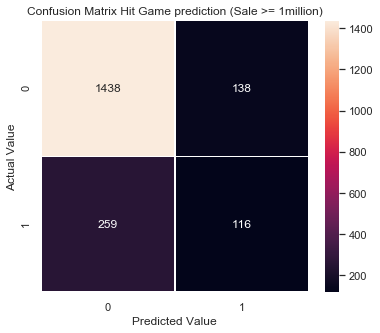

In [4]:
y = df_model['isHit'].values
df_model = df_model.drop(columns=['isHit','Global_Sales'],axis=1)
X = df_model.values
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.30, random_state=40)
#Use Random Forest Classifier to predict the dataset
radm = RandomForestClassifier(random_state=40).fit(Xtrain, ytrain)
y_val = radm.predict_proba(Xtest)
print("Validation accuracy: ", sum(pd.DataFrame(y_val).idxmax(axis=1).values
                                   == ytest)/len(ytest))
# Print the genres that are most influential on the sale
indices = np.argsort(radm.feature_importances_)[::-1]
# Print the feature ranking
print('Most influential features ranking')
for f in range(14):
    print('%d. feature %d %s (%f)' % (f+1 , indices[f], df_model.columns[indices[f]],
                                      radm.feature_importances_[indices[f]]))
predictions = radm.predict(Xtest)
print(classification_report(ytest, predictions))
#Create heatmap visualization on the result
fig, ax = plt.subplots(figsize=(6,5))
sns.heatmap(confusion_matrix(ytest, predictions),annot=True, linewidths=.8, ax=ax, fmt="d").set(xlabel='Predicted Value', ylabel='Actual Value')
ax.set_title('Confusion Matrix Hit Game prediction (Sale >= 1million)')

In [5]:
score = []
#Create a dataset from the genre and its importance
for f in range(12):
    score.append([df_model.columns[indices[f]],round(radm.feature_importances_[indices[f]],5)])
#Visualize using bar chart 
genre_score_df = pd.DataFrame(data=score , columns = ['Feature', 'Score']) 
layout = go.Layout(
    title="Influence of features on making hit games (Sale >= 1million)",
    xaxis=dict( title='Score' ), height=600, width=800
    )

trace = go.Bar(
            x=genre_score_df.Score,
            y=genre_score_df.Feature,
            text=genre_score_df.Score,
            textposition='auto',
            orientation = 'h',
            )
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)
fig.write_html('web/src/assets/influence_of_features_on_hit_game.html')